<a href="https://colab.research.google.com/github/raz0208/Natural-Gas-Price-Interpolation-Forecasting/blob/main/Advance_Quantitative_Research-Natural_Gas_Price_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Gas Price Interpolation Forecasting

In [1]:
# Import Required Libraries and Pakages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from datetime import timedelta

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load and Read dataset
df = pd.read_csv('Nat_Gas.csv')

df.head(10)

,Dates,Prices
0,10/31/20,10.10
1,11/30/20,10.30
2,12/31/20,11.00
3,1/31/21,10.90
4,2/28/21,10.90
5,3/31/21,10.90
6,4/30/21,10.40
7,5/31/21,9.84
8,6/30/21,10.00
9,7/31/21,10.10


## Data Inspection And Undrestanding

In [3]:
# Check and convert data column to date format
df['Dates'] = pd.to_datetime(df['Dates'])

# Sort the data by "date"
df = df.sort_values("Dates")

# Check for duplication
duplicates = df.duplicated().sum()

# Check for Missing Values
missing_val = df.isnull().sum()

# Print the info
print("Duplicate data = ", duplicates)
print("Missing Values = ", missing_val, "\n")

# Print summary of the dataset
summary_stats = df['Prices'].describe()
print("\nSummary statistics:\n", summary_stats, "\n")

# Print the sorted dataset
df.head(10)

Duplicate data =  0
Missing Values =  Dates     0
Prices    0
dtype: int64 


Summary statistics:
 count    48.000000
mean     11.207083
std       0.757897
min       9.840000
25%      10.650000
50%      11.300000
75%      11.625000
max      12.800000
Name: Prices, dtype: float64 



,Dates,Prices
0,2020-10-31,10.10
1,2020-11-30,10.30
2,2020-12-31,11.00
3,2021-01-31,10.90
4,2021-02-28,10.90
5,2021-03-31,10.90
6,2021-04-30,10.40
7,2021-05-31,9.84
8,2021-06-30,10.00
9,2021-07-31,10.10


#### **Natural Gas Monthly Prices (Time Series Plot)**
This shows the raw data over time. You can clearly see an upward trend (prices generally increasing from 2020 to 2024) and seasonality (prices spike in winter months and drop in summer months), which is typical for natural gas demand.

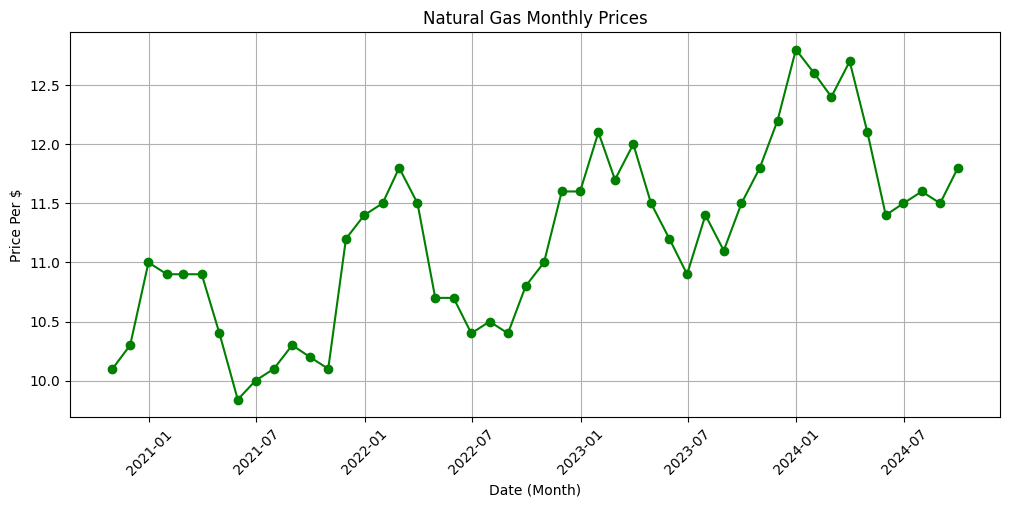

In [4]:
# Visualise the data
plt.figure(figsize=(12, 5))
plt.plot(df['Dates'], df['Prices'], marker='o', linestyle='-', color='green')
plt.title('Natural Gas Monthly Prices')
plt.xlabel('Date (Month)')
plt.ylabel('Price Per $')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## Statistical Tests & Analysis

**STL Decomposition (Trend, Seasonal, Residual):**

**Trend:** Isolates the long-term direction of the price. It confirms the steady increase in price over the years, ignoring the month-to-month volatility.

**Seasonal:** Isolates the repeating annual pattern. This confirms that gas prices follow a predictable cycle every 12 months.

**Residual:** This is the "noise" or random error left over after removing the Trend and Seasonality.


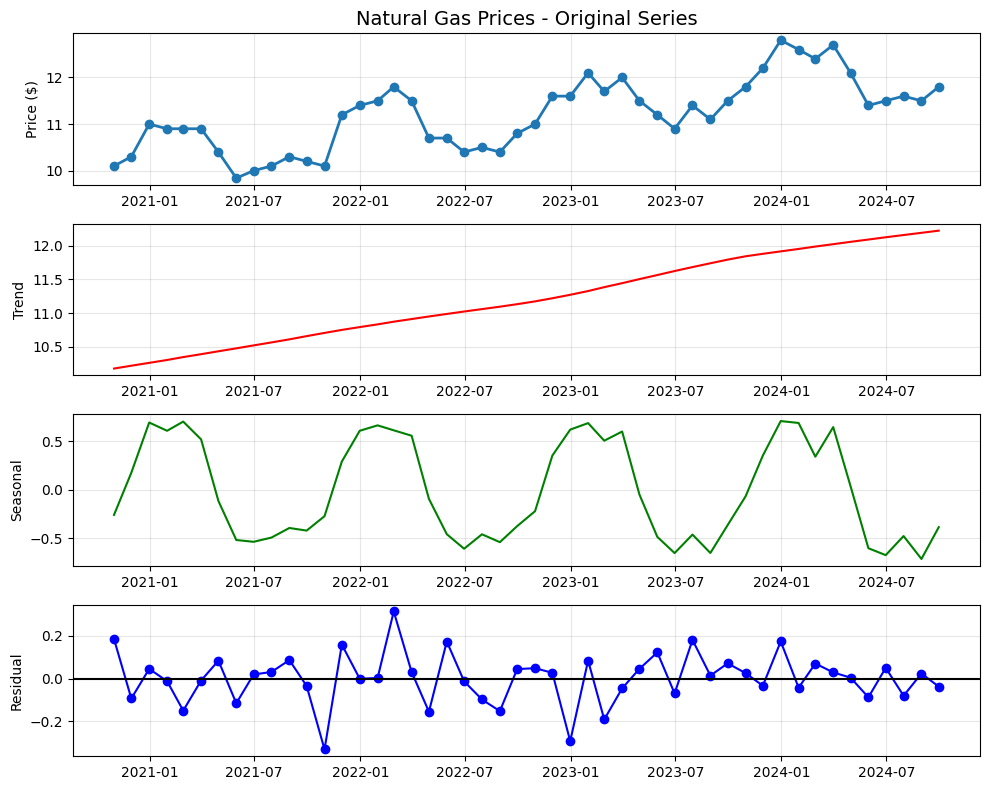

In [5]:
# Implement Seasonal Decomposition

# Creat monthly time-indexed series
df_month = df.set_index("Dates").asfreq('M')

# Perform STL
stl = STL(df_month['Prices'], period=12)
result = stl.fit()

# Extract componenets
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Visualise decomposition
plt.figure(figsize=(10, 8))

# Original Price plot
plt.subplot(4, 1, 1)
plt.plot(df_month['Prices'], linewidth=2, marker='o')
plt.title('Natural Gas Prices - Original Series', fontsize=14)
plt.ylabel('Price ($)')
plt.grid(alpha=0.3)

# Trend plot
plt.subplot(4, 1, 2)
plt.plot(trend, color='red')
plt.title('', fontsize=14)
plt.ylabel('Trend')
plt.grid(alpha=0.3)

# Seasonal plot
plt.subplot(4, 1, 3)
plt.plot(seasonal, color='green')
plt.title('', fontsize=14)
plt.ylabel('Seasonal')
plt.grid(alpha=0.3)

# Residual plot
plt.subplot(4, 1, 4)
plt.plot(residual, color='blue', marker='o')
plt.axhline(0, color='black', linewidth=1.5, linestyle='-')
plt.title('', fontsize=14)
plt.ylabel('Residual')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical Tests & Analysis: Stationart Check

 - **ADF (Augmented Dickey-Fuller) Test Results**
   - **Conclusion:** The data is Non-Stationary.
   - **The Logic:** The Null Hypothesis ($H_0$) of the ADF test is that the data is non-stationary (has a unit root). We want to reject this to prove the data is stationary.
    - **ADF Test Result:**
      - `p-value (0.97):` This is very high (much greater than 0.05). This means you fail to reject the null hypothesis.
      - `Test Statistic (0.218):` This is higher than the critical values (-2.94, etc.).
    - **Meaning:** The statistical evidence confirms that the data has a time-dependent structure (trend/seasonality) and cannot be modeled as a stationary process without modification (like differencing).

 - **KPSS (Kwiatkowski-Phillips-Schmidt-Shin) Test Results**
 - **Conclusion:** The data is Non-Stationary.
   - **The Logic:** The Null Hypothesis ($H_0$) of the KPSS test is the opposite of ADF: it assumes the data is stationary. We want to fail to reject this to confirm stationarity.
   - **KPSS Test Result:**
     - `p-value (0.01):` This is very low (below 0.05). This means you reject the null hypothesis.
     - `Test Statistic (0.730):` This is higher than the 5% critical value (0.463).Meaning: This reinforces the ADF result. The data has a significant trend or structural break that makes the mean or variance change over time.

- **ACF (Autocorrelation Function):** This chart shows how correlated the price is with its past values. If the blue bars decrease very slowly (which they likely do here), it indicates the data is non-stationary and heavily influenced by a trend.

- **PACF (Partial Autocorrelation Function):** This shows the direct correlation between a month and a past month, removing the "middle-man" influence of the months in between. This is primarily used to determine the parameters for AR (AutoRegressive) models.

**Summary**
Both tests and the plots agree: The data is non-stationary. To predict future prices accurately using statistical models (like ARIMA), you would need to remove the trend and seasonality (e.g., by differencing the data) or use a model that explicitly handles them (like a regression model with seasonal variables).

ADF Test Results:
ADF Test Statistic: 0.21807686169999427
p-value: 0.973257438844869
Lags Used: 10
Number of Observation used: 37
Critical Value 1%: -3.6209175221605827
Critical Value 5%: -2.9435394610388332
Critical Value 10%: -2.6104002410518627


KPSS Test Results:
KPSS Test Statistic: 0.7304095231737717
p-value: 0.010780952438748024
Lags Used: 4
Critical value 10%: 0.347
Critical value 5%: 0.463
Critical value 2.5%: 0.574
Critical value 1%: 0.739




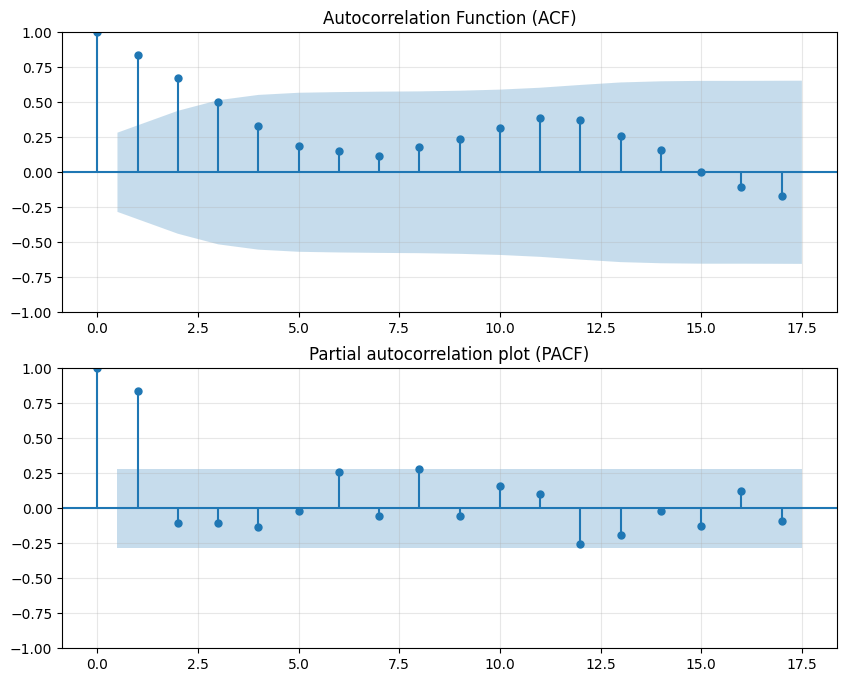

In [6]:
# Augmented Dickey-Fuller Test
adf_result = adfuller(df_month['Prices'].dropna())
print("ADF Test Results:")
print(f"ADF Test Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print(f"Lags Used: {adf_result[2]}")
print(f"Number of Observation used: {adf_result[3]}")
for key, value in adf_result[4].items():
    print(f"Critical Value {key}: {value}")
print("\n")

# KPSS Test
kpss_result = kpss(df_month['Prices'].dropna(), regression='c')
print("KPSS Test Results:")
print(f"KPSS Test Statistic: {kpss_result[0]}")
print(f"p-value: {kpss_result[1]}")
print(f"Lags Used: {kpss_result[2]}")
for key, value in kpss_result[3].items():
  print(f"Critical value {key}: {value}")
print("\n")

# adf Visialisation
plt.figure(figsize=(10, 8))

# ACF Plot
plt.subplot(2, 1, 1)
plot_acf(df_month['Prices'], ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')
plt.grid(alpha=0.3)

# PACF Plot
plt.subplot(2, 1, 2)
plot_pacf(df_month['Prices'], ax=plt.gca())
plt.title('Partial autocorrelation plot (PACF)')
plt.grid(alpha=0.3)

plt.show()

# Model Implementation: Time Series Forcasting


## SARIMA Model

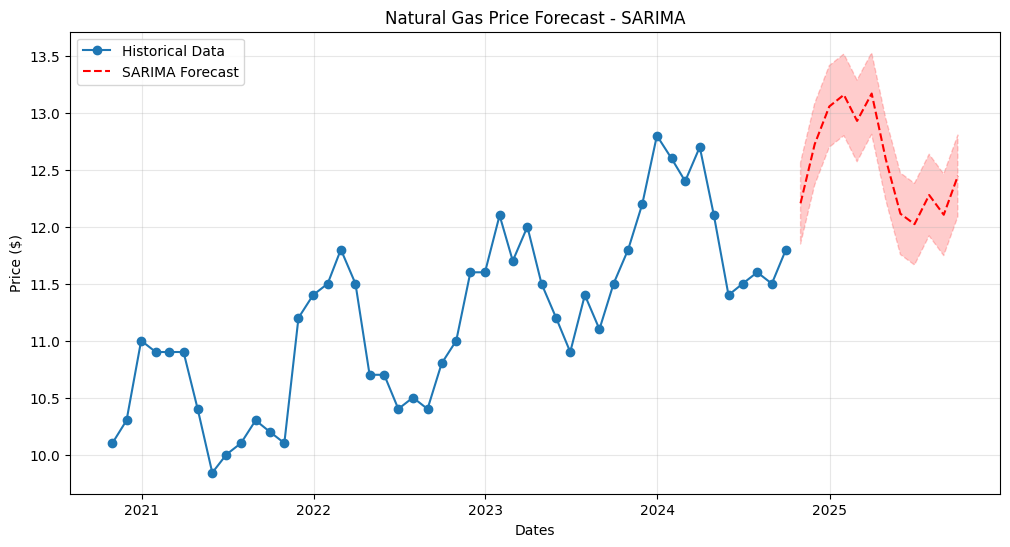

In [7]:
# Fit SARIMA Model
SARIMA_model = SARIMAX(df_month['Prices'],
                       order=(1, 1, 1), # Order (p,d,q): (1,1,1) and (0, 1, 1)
                       seasonal_order=(1, 1, 2, 12), # Seasonal Order (P,D,Q,s): (1,1,1,12), (0, 1, 1, 12), (1, 1, 0, 12), and (1, 1, 2, 12)
                       enforce_stationarity=False,
                       enforce_invertibility=False
                       )
SARIMA_result = SARIMA_model.fit()
# # Print Summary
# print(SARIMA_result.summary())

# SARIMA Model Forecast
steps = 12
SARIMA_forecast = SARIMA_result.get_forecast(steps=steps)
SARIMA_forecast_mean = SARIMA_forecast.predicted_mean
SARIMA_conf_int = SARIMA_forecast.conf_int()

# SARIMA Model Forecasting Visualisation
plt.figure(figsize=(12, 6))
plt.plot(df_month.index, df_month['Prices'], label='Historical Data', marker='o', linestyle='-') # Historical data
plt.plot(SARIMA_forecast_mean.index, SARIMA_forecast_mean, label='SARIMA Forecast', linestyle='--', color='red') # SARIMA Forecast
plt.fill_between(SARIMA_forecast_mean.index, SARIMA_conf_int.iloc[:, 0],
                 SARIMA_conf_int.iloc[:, 1], linestyle='--', color='red', alpha=0.2) # Confidence Interwall
plt.title('Natural Gas Price Forecast - SARIMA')
plt.xlabel('Dates')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



## ETS Model

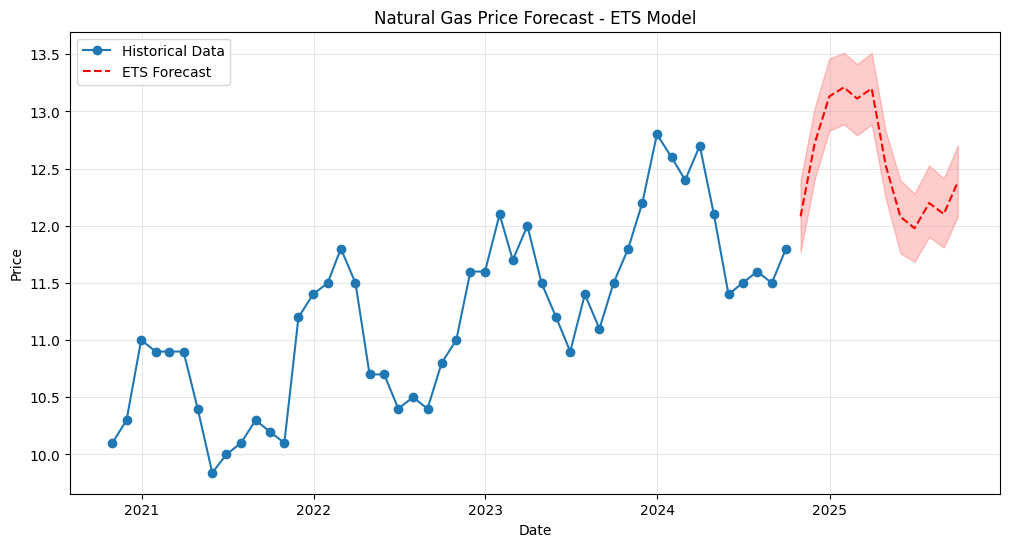


 ETS Model AIC: -5.060479418488299

Forecasted Prices (Next 12 Months):
                 mean
2024-10-31  12.081946
2024-11-30  12.721063
2024-12-31  13.131762
2025-01-31  13.210674
2025-02-28  13.112334
2025-03-31  13.200767
2025-04-30  12.524853
2025-05-31  12.079237
2025-06-30  11.978114
2025-07-31  12.199000
2025-08-31  12.103075
2025-09-30  12.384842


In [8]:
# Fit ETS Model
ETS_model = ETSModel(df_month['Prices'],
                     error='add',
                     trend='add',
                     seasonal='mul',
                     seasonal_periods=12
                     )
ETS_result = ETS_model.fit()

# ETS Model forecast
ETS_forecast = ETS_result.get_prediction(start=df_month.index[-1] + timedelta(days=1),
                                         end=df_month.index[-1] + timedelta(days=365))
ETS_forecast_df = ETS_forecast.summary_frame()

# ETS Model forecast Visualisation
plt.figure(figsize=(12, 6))
plt.plot(df_month.index, df_month['Prices'], label='Historical Data', marker='o', linestyle='-') # Plot Historical Data
plt.plot(ETS_forecast_df.index, ETS_forecast_df['mean'], label='ETS Forecast', color='red', linestyle='--') # Plot ETS Forecast
plt.fill_between(ETS_forecast_df.index, ETS_forecast_df['pi_lower'], ETS_forecast_df['pi_upper'],
                 color='red', alpha=0.2) # Plot Confidence Intervals
plt.title('Natural Gas Price Forecast - ETS Model')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


print("\n", "ETS Model AIC:", ETS_result.aic)
print("\nForecasted Prices (Next 12 Months):")
print(ETS_forecast_df[['mean']].head(12))

## ML Model: Regression with Time Variable

In [ ]:
# # Load dataset
# df = pd.read_csv('Nat_Gas.csv')

# # Convert Dates column to datetime
# df['Dates'] = pd.to_datetime(df['Dates'])

# # Create time index
# df_model = df.copy()
# df_model["TimeIndex"] = (df_model["Dates"] - df_model["Dates"].min()).dt.days

# df_model.head(10)

,Dates,Prices,TimeIndex
0,2020-10-31,10.10,0
1,2020-11-30,10.30,30
2,2020-12-31,11.00,61
3,2021-01-31,10.90,92
4,2021-02-28,10.90,120
5,2021-03-31,10.90,151
6,2021-04-30,10.40,181
7,2021-05-31,9.84,212
8,2021-06-30,10.00,242
9,2021-07-31,10.10,273


In [ ]:
# # -----------------------------------------------
# # 2. Train-test split
# # -----------------------------------------------
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
# X = df_model[["TimeIndex"]]
# y = df_model["Prices"]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# # -----------------------------------------------
# # 3. Create and fit regression model
# # -----------------------------------------------
# model = LinearRegression()
# model.fit(X_train, y_train)

# # -----------------------------------------------
# # 4. Evaluate model performance
# # -----------------------------------------------
# y_pred = model.predict(X_test)

# mae = mean_absolute_error(y_test, y_pred)
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# print("Model Intercept:", model.intercept_)
# print("Model Coefficient:", model.coef_[0])
# print("MAE:", mae)
# print("RMSE:", rmse)


Model Intercept: 10.291937612829328
Model Coefficient: 0.0012381259696856515
MAE: 0.5743451988900465
RMSE: 0.6309450744464152


In [ ]:
# # -----------------------------------------------
# # 5. Function to predict gas price for any date
# # -----------------------------------------------
# def get_price_estimate(input_date):
#     input_date = pd.to_datetime(input_date)
#     time_index = (input_date - df_model["Dates"].min()).days
#     pred_price = model.predict([[time_index]])
#     return float(pred_price)

# # Example usage:
# print("Estimated Price for 2025-05-30:", get_price_estimate("2025-05-30"))
# print("Estimated Price for 2025-01-30:", get_price_estimate("2025-08-31"))

Estimated Price for 2025-05-30: 12.362084234143737
Estimated Price for 2025-01-30: 12.477229949324503


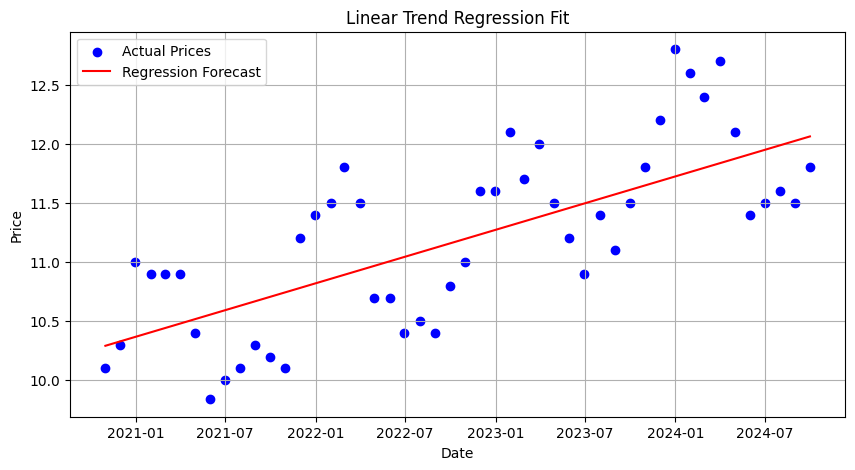

In [ ]:
# # -----------------------------------------------
# # 6. Plot regression fit vs actual prices
# # -----------------------------------------------
# plt.figure(figsize=(10,5))
# plt.scatter(df_model["Dates"], df_model["Prices"], label="Actual Prices", color="blue")
# plt.plot(df_model["Dates"], model.predict(X), label="Regression Forecast", color="red")
# plt.xlabel("Date")
# plt.ylabel("Price")
# plt.title("Linear Trend Regression Fit")
# plt.legend()
# plt.grid(True)
# plt.show()

In [9]:
# # 1. Load Data
# df = pd.read_csv('Nat_Gas.csv')
# df['Dates'] = pd.to_datetime(df['Dates'])

# # 2. Feature Engineering
# # We need to convert dates into numerical features the regression can understand.
# # 'Days_from_start': Captures the linear Trend
# # 'Sin_Month' & 'Cos_Month': Captures the cyclical Seasonality (smooth curve)

# df['Days_From_Start'] = (df['Dates'] - df['Dates'].min()).dt.days
# df['Month'] = df['Dates'].dt.month

# # Create harmonic features for seasonality (better than dummy variables for continuous time)
# # 12 months in a cycle
# df['Sin_Month'] = np.sin(2 * np.pi * df['Month'] / 12)
# df['Cos_Month'] = np.cos(2 * np.pi * df['Month'] / 12)

In [10]:
# # 3. Fit Linear Regression
# features = ['Days_From_Start', 'Sin_Month', 'Cos_Month']
# X = df[features]
# y = df['Prices']

# model = LinearRegression()
# model.fit(X, y)

# # 4. Estimation Function (As requested in original task)
# def estimate_price(date_str):
#     """
#     Takes a date string (YYYY-MM-DD) and returns the estimated price
#     using the trained linear regression model.
#     """
#     target_date = pd.to_datetime(date_str)
#     start_date = df['Dates'].min()

#     # Calculate features for the new date
#     days_diff = (target_date - start_date).days
#     month = target_date.month

#     sin_feat = np.sin(2 * np.pi * month / 12)
#     cos_feat = np.cos(2 * np.pi * month / 12)

#     # Predict
#     input_data = pd.DataFrame({
#         'Days_From_Start': [days_diff],
#         'Sin_Month': [sin_feat],
#         'Cos_Month': [cos_feat]
#     })

#     prediction = model.predict(input_data)[0]
#     return prediction

# # 5. Extrapolate 1 Year into the Future for Visualization
# future_dates = pd.date_range(start=df['Dates'].min(), end=df['Dates'].max() + timedelta(days=365), freq='D')
# future_df = pd.DataFrame({'Dates': future_dates})

# future_df['Days_From_Start'] = (future_df['Dates'] - df['Dates'].min()).dt.days
# future_df['Month'] = future_df['Dates'].dt.month
# future_df['Sin_Month'] = np.sin(2 * np.pi * future_df['Month'] / 12)
# future_df['Cos_Month'] = np.cos(2 * np.pi * future_df['Month'] / 12)

# future_df['Predicted_Price'] = model.predict(future_df[features])

In [11]:
# # 6. Visualization
# plt.figure(figsize=(12, 6))
# plt.plot(df['Dates'], df['Prices'], 'bo', label='Actual Prices')
# plt.plot(future_df['Dates'], future_df['Predicted_Price'], 'r-', label='Regression Trend + Seasonality', alpha=0.7)

# plt.title('Natural Gas Price Model: Linear Trend + Sin/Cos Seasonality')
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.show()

In [12]:
# # Test the estimator function
# test_date = "2025-06-15"
# print(f"Regression Coefficients:\nTrend (Slope): {model.coef_[0]:.5f} per day\n")
# print(f"Estimated Price for {test_date}: ${estimate_price(test_date):.2f}")